# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="envs\Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Example action
actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
print("Example action", actions)
actions = np.clip(actions, -1, 1) 
print("Example action (clipped)", actions)

# examine the state space 
states = env_info.vector_observations
print("Number of states:", len(states))
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])



Number of agents: 2
Size of each action: 2
Example action [[ 0.23286555  1.13143038]
 [-0.07632226 -1.14613254]]
Example action (clipped) [[ 0.23286555  1.        ]
 [-0.07632226 -1.        ]]
Number of states: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {:.5f}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.00000
Score (max over agents) from episode 2: 0.00000
Score (max over agents) from episode 3: 0.10000
Score (max over agents) from episode 4: 0.00000
Score (max over agents) from episode 5: 0.00000


# 4 Training an Agent using MADDPG

## 4.1 Import libraries

In [7]:
import numpy as np
import random
import torch
from unityagents import UnityEnvironment
from collections import namedtuple, deque
import matplotlib.pyplot as plt

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 4.2 Define Helpful Functions

In [8]:
def hidden_init(layer):
    """
    Takes a Network layer and initialises the weights
    params
    ======
    layer (torch.nn.layer) the layer to be initialised
    """
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

def flatten(tensor):
    """
    Takes a tensor and flattens and dimentions other than the first
    params
    ======
    tensor (tensor like) the multi-dim tensor to be flattened
    """
    return torch.reshape(tensor, (tensor.shape[0], -1,))

def set_seeds(seed = 73):
    """
    Sets the seed for random number generation for Numpy and Torch
    params
    ======
    seed (integer) the seed to set for random number generation
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

def graph_scores(scores): 
    """
    Produces a graph of the average scores
    Params
    =====
    scores (list) list of scores to be plotted
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores) + 1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()  

## 4.3 Define Actor and Critic Models

In [9]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Sets the weights of the network to more uniform random values
        """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))
        

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, full_state_size, full_action_size, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of both agents states
            action_size (int): Dimension of both agents actions
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        #self.fc1 = nn.Linear(full_state_size, fc1_units)
        #self.fc2 = nn.Linear(fc1_units+full_action_size, fc2_units)
        self.fc1 = nn.Linear(full_state_size + full_action_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Build an actor (policy) network that maps states -> actions.
        """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, full_state, full_action):
        """
        Build a critic (value) network that maps (state, action) pairs -> Q-values.
        """
        #xs = F.leaky_relu(self.fc1(full_state))
        #x = torch.cat((xs, full_action), dim=1)
        full = torch.cat((full_state, full_action), dim=1)
        x = self.bn1(F.relu(self.fc1(full)))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## 4.5 Experience Replay Buffer

In [10]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size=int(1e5), batch_size=256):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """
        Add a new experience to memory.
        params
        =====
        states (Numpy Array) the environment state information to store
        action (Numpy Array) the agent action information to store
        reward (Numpy Array) the reward for the envronemnt action
        next_state (numpy array) the state of the envirnment after the actions were taken
        done (numpy array) the flags indicating if the episode is complete or  not
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
    
    def ready_for_sampling(self):
        """
        Returns True if the Replay Buffer has sufficient experiences to sample
        otherwise returns False
        """
        if len(self.memory) >= self.batch_size:
            return True
        else:
            return False

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## 4.6 Noise Generator

In [11]:
# from https://github.com/songrotek/DDPG/blob/master/ou_noise.py
class OUNoise:

    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return torch.tensor(self.state).float()
    

## 4.7 Define DDPG Agent

In [12]:
class DDPG_Agent:
    """
    Implementation of a DDPG Agent
    """
    def __init__(self, state_size, action_size, num_agents=1,
                 fc1=256, fc2=128,
                 lra= 1e-3, lrc= 1e-4, tau=1e-2):
        """
        Initialise the DDPG Agent
        params
        ======
        state_size (integer) the size of the state space for the Agent
        action_size (integer) the size of the action space for the Agent
        num_agents (integer) the number of agents in the System
        fc1 (integer) the number of nodes in the first hidden layer
        fc2 (integer) the number of nodes in the second hidden layer
        tau (float) the Tau value to use in soft updates of weights
        """
        super(DDPG_Agent, self).__init__()
        self.action_size = action_size
        self.tau = tau
        
        # The Critics will use the full state and action for all agents so calculate these
        critic_state_size = num_agents * state_size
        critic_action_size = num_agents * action_size
        
        # Define local network
        self.actor = Actor(state_size, action_size, fc1_units=fc1, fc2_units=fc2).to(device)
        self.critic = Critic(critic_state_size, critic_action_size, 
                             fc1_units=fc1, fc2_units=fc2).to(device)
        
        # Define target networks
        self.target_actor = Actor(state_size, action_size, fc1_units=fc1, fc2_units=fc2).to(device)
        self.target_critic = Critic(critic_state_size, critic_action_size, 
                                    fc1_units=fc1, fc2_units=fc2).to(device)
        
        # Define Optimisers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lra, weight_decay=0.0)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lrc, weight_decay=0.0)
        
        # Define Noise Generator
        self.noise = OUNoise(action_size)
        
        # Initialized target and actors to have the same weights
        self.hard_update(self.actor, self.target_actor)
        self.hard_update(self.critic, self.target_critic)
        
        # Log out configuraton
        print("Agent Configuration")
        print("\tNetwork: {} -> {} -> {} -> {}".format(state_size, fc1, fc2, action_size) )
        print("\tActor LR: {:.5f}\tCritic LR: {:.5f}\tTau: {:.5f}".format(lra, lrc, tau))
        print("----------------------------------------------\n")
        
    def reset(self):
        """Resets the noise level"""
        self.noise.reset()
        
    def act(self, state, noise_scale=0.0):
        """
        performs a single Policy step using the local actor network 
        for the agent with an optional noise element
        params
        ======
        state (numpy array) the current environment state to take the action from
        noise_scale (float) the amount of noise to apply to the action (0.0 means no noise)
        """
        state = torch.from_numpy(state).float().to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state) + noise_scale * self.noise.noise()
        self.actor.train()
        return action
    
    def target_act(self, state, noise_scale=0.0):
        """
        performs a single Policy step using the target actor network 
        for the agent with an optional noise element
        params
        ======
        state (numpy array) the current environment state to take the action from
        noise_scale (float) the amount of noise to apply to the action (0.0 means no noise)
        """
        state = torch.from_numpy(state).float().to(device)
        with torch.no_grad():
            action = self.target_actor(state) + noise_scale * self.noise.noise()
        return action
        
    def hard_update(self, target, source):
        """
        Hard update of network weights so that the local and target networks are the same
        params
        ======
        local_model: PyTorch model (weights will be copied from)
        target_model: PyTorch model (weights will be copied to)
        """
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)
      
    def soft_update_targets(self):
        """
        Performs the soft update across both the actor and critic networks
        """
        self.soft_update(self.actor, self.target_actor)
        self.soft_update(self.critic, self.target_critic)
        
    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

## 4.8 Define MADDPG Agent

In [13]:
class MADDPG_Agent:
    """
    Impelmentation of a Multi-Agent DDPG Agent (MADDPG)
    """
    def __init__(self, state_size, action_size, num_agents = 2, 
                 fc1=256, fc2=128,
                 gamma = 0.99, tau=5e-2,
                 lra= 1e-3, lrc= 1e-4,
                 batch_size = 256, replay_buffer_size=int(1e6),
                 learn_after = 300, learn_every=1, learn_epoch=1):
        """
        Initialise the MADDPG Agent
        params
        ======
        state_size (integer) the size of the state space for the environment
        action_size (integer) the size of the action space for the environment
        num_agents (integer) the number of agents to simulate
        fc1 (integer) the number of nodes in in the first hidden layer of the Agents
        fc2 (integer) the number of nodes in in the second hidden layer of the Agents
        gamma (float) the discount factor for future rewards
        tau (float) the tau value for soft updates of network weights
        lra (float) the learning rate for the Actor
        lrc (float) the learning rate for the Critic
        batch_size (integer) the batch size for learning samples
        replay_buffer_size(integer) the size of the replay buffer
        learn_after (integer) the number of episodes to wait before learning
        learn_every (integer) the frequency of learning (in steps)
        learn_epoch (integer) the number of times to perform learning at each learning step         
        """
        super(MADDPG_Agent, self).__init__()
        print("MADDPG Configuration")
        print('\tGamma {:.5f}\tBatch Size: {}\tReplay Buffer Size: {}'
              .format(gamma, batch_size, replay_buffer_size))
        print("\tStart Learning after {} episodes".format(learn_after))
        print("\tLearn Every {} step". format(learn_every))
        print("\tLearn {} times each learning step".format(learn_epoch))
        print("----------------------------------------------\n")
        
        
        self.agents =[DDPG_Agent(state_size = state_size, action_size = action_size, 
                                 num_agents = num_agents, tau=tau,
                                 lra=lra, lrc=lrc,
                                 fc1=fc1, fc2=fc2) for _ in range(num_agents)]
        self.batch_size = batch_size
        self.memory = ReplayBuffer(replay_buffer_size, self.batch_size)
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.learn_after = learn_after
        self.timestep = 0
        self.learn_every = learn_every
        self.learn_epoch = learn_epoch
        
        
    
    def reset(self):
        """
        Performs a reset on all agents in the group
        """
        for agent in self.agents:
            agent.reset()
    
    def act(self, states, noise_scale = 0.0):
        """
        Performs an single step using the local policy for each of the agents in the group
        params
        ======
        states (numpy array) the set of environment states for each of the agnets
        noise_scale (float) the amount of noise to add to the actions (0.0 means no noise)
        """
        actions = []
        for agent_id, agent in enumerate(self.agents):
            agent_state = states[agent_id, :]
            action = agent.act(agent_state, noise_scale)
            actions.append(action)
            
        actions = np.concatenate(actions, axis=0)
        return actions
    
    def update_targets(self):
        """ Performs a soft update of all environment weights for each agent in the group"""
        for agent in self.agents:
            agent.soft_update_targets()
            
    def step(self, i_episode, states, actions, rewards, next_states, dones):
        """
        Performs a set in the learning process; this includes
        - saving the current experience
        - performing learning across each agent
        
        params
        =====
        i_episode (integer) the episode number
        states (numpy array) the environment state for each of the agents before the action was taken
        actions(numpy array) the actions taken by each of the agents
        rewards (numpy array) the reward obtained for each agent from the actions
        next_states (numpy array) the next environment state for eahc of the agents after the action was taken
        dones (numpy array) the flags for each agent to indicate if the game is over
        """
        # Store step in memory
        self.memory.add(states, actions, rewards, next_states, dones)
        self.timestep += 1
        # Start learning if there are sufficient samples to learn from
        if (len(self.memory) >= self.batch_size) and (i_episode >= self.learn_after):
            if (self.timestep % self.learn_every) == 0:
                for _ in range(self.learn_epoch):
                    for agent_id in range(len(self.agents)):
                        samples = self.memory.sample()
                        self.learn(agent_id, samples)
                    self.update_targets()

    def target_act(self, states, noise_scale=0.0):
        """
        obtains the set of actions using the policy for each of the target actors based 
        on the provided environment state
        params
        =====
        states (numpy array) the envirionment state for each agent
        noise_scale (float) the amount of noise to add to the actions (0.0 means no noise added)
        """
        
        actions = torch.zeros((len(states), self.num_agents, 
                                          self.action_size), dtype=torch.float, device=device)
        for agent_id, agent in enumerate(self.agents):
            agent_state = states[:,agent_id, :]
            actions[:, agent_id] = agent.target_act(agent_state.numpy(), noise_scale)
        return actions
        
        
    def learn(self, agent_id, samples):
        """
        performs the main MADDPG learning loop for a single agent
        params
        ======
        agent_id (integer) the id of the agent that will learn (0 is the first agent)
        samples (torch Tensor array) the batch of experiences to learn from
        """
        states, actions, rewards, next_states, dones = samples
        
        full_states = flatten(states)
        full_actions = flatten(actions)
        full_next_states = flatten(next_states)
        agent_dones = dones[:,agent_id].view(-1,1)
        agent_rewards = rewards[:, agent_id].view(-1,1)
        
        agent = self.agents[agent_id]
        agent.critic_optimizer.zero_grad()
        
        # ---------------------------- update critic ---------------------------- #
        #critic loss = batch mean of (y- Q(s,a) from target network)^2
        #y = reward of this timestep + discount * Q(st+1,at+1) from target network
        target_actions = flatten(self.target_act(next_states))
        
        #with torch.no_grad():
        q_next = agent.target_critic(full_next_states, target_actions)
            
        q_target = agent_rewards + self.gamma * q_next * (1 - agent_dones)
        
        # Compute Critic loss
        q_expected = agent.critic(full_states, full_actions)
        
        critic_loss = F.mse_loss(input=q_expected, target=q_target)
        
        # Minimise the loss
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 1)
        agent.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        agent.actor_optimizer.zero_grad()
        actor_full_actions = torch.zeros((len(states), self.num_agents, self.action_size), dtype=torch.float, device=device)
        for agent_no, agent_ref in enumerate(self.agents):
            if agent_no != agent_id:
                actor_full_actions[:, agent_no] = agent_ref.actor(states[:,agent_no,:]).detach()
            else:
                actor_full_actions[:, agent_no] = agent_ref.actor(states[:,agent_no,:])
        
        actor_full_actions = flatten(actor_full_actions)
        
        # get the policy gradient
        actor_loss = -agent.critic(full_states, actor_full_actions).mean()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 1)
        agent.actor_optimizer.step()
        

    def save(self, run_id):
        """
        Saves the current state of the agent
        params
        ======
        run_id (string) the name to save the agent state as
        """
        for agent_id, agent in enumerate(self.agents):
            torch.save(agent.actor.state_dict(), run_id + 'checkpoint_actor_local_' + str(agent_id) + '.pth')
            torch.save(agent.critic.state_dict(), run_id + 'checkpoint_critic_local_' + str(agent_id) + '.pth')
            torch.save(agent.target_actor.state_dict(), run_id + 'checkpoint_actor_target_' + str(agent_id) + '.pth')
            torch.save(agent.target_critic.state_dict(), run_id + 'checkpoint_critic_target_' + str(agent_id) + '.pth')

    def load(self, run_id):
        """
        Loads a pre-saved state of the agent
        params
        ======
        run_id (string) the name of the pre-saved agent to load
        """
        for agent_id, agent in enumerate(self.agents):
            agent.actor.load_state_dict(torch.load(run_id + 'checkpoint_actor_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.critic.load_state_dict(torch.load(run_id + 'checkpoint_critic_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.target_actor.load_state_dict(torch.load(run_id + 'checkpoint_actor_target_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.target_critic.load_state_dict(torch.load(run_id + 'checkpoint_critic_target_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))

## 4.9 Define Training function

In [14]:
def adapt_noise_scale(period_average, min_noise, max_noise, goal_score):
    """
    Returns a noise scale based on the current progress towards the goal score
    and a min and max noise scale
    params
    =====
    period_average (float) the current score to base the noise on
    min_noise (float) the minimum value for the noise scale
    max_noise (float) the maximum value for the noise scale
    goal_score (float) the target score for the environment
    """
    noise = (1 - (period_average / goal_score)) * (max_noise - min_noise)
    if noise > max_noise:
        noise = max_noise
    if noise < min_noise:
        noise = min_noise
    
    return noise

def decay_noise_scale(noise, min_noise, max_noise, decay_over):
    """
    Returns a decayed noise value based on the current noise value
    the min and max noise scales and the period to decay over
    params
    =====
    noise (float) the current noise value
    min_noise (float) the minimum noise level
    max_noise (float) the maximum noise level
    decay_over (float) the period over which to decay the noise
    """
    new_noise = noise - (max_noise - min_noise) / float(decay_over)
    if noise < min_noise:
        new_noise = min_noise
    return new_noise

In [15]:
def train_agent(env, agent, run_id,  max_episodes = 10000,
                noise_start = 0.5, min_noise = 0.05, decay_noise_after = 0, decay_noise_over = 0, 
                use_adaptive_noise = False, use_noise_decay = False,
                goal_period=100, goal_score = 0.5, output_every = 100):
    """
    Training function for a MADDPG agent in an environment
    params
    =====
    env (UnitEnvironment) the Unity Environment used to train the agents against
    agent (MADDPG_Agent) the MADDPG Agent to train
    run_id (String) the name of the run - used when storing the agent wieghts
    max_episodes (integer) the maximum number of episodes to train for
    noise_start (float) the starting noise scale
    min_noise (float) the minumum level for the noise scale
    decay_noise_after (integer) the number of epsisodes to wait before decaying noise
    decay_noise_over (integer) the number of episodes to decay noise over
    use_adaptive_noise (boolean) Flag to indicate wheter to use an Adaptive noise scheme or not
    use_noise_decay (boolean) Flag to indicate whether to use a Noise Decay scheme or not
    goal_period (integer) the number of episodes to measure the goal mean over
    goal_score (float) the target goal score to achieve
    output_every (integer) the frequence to log interim results
    """
    
    # Log Training Config
    print("Training Configuration")
    print("\tGoal period {}\t Goal Score {:.2}\tOutput results every {} episode"
         .format(goal_period, goal_score, output_every))
    if use_adaptive_noise:
        print("\tAdaptive Noise\t Noise Max: {:.5f}\t Noise Min: {:.5f}"
             .format(noise_start, min_noise))
    else:
        if use_noise_decay:
            print("\tDecaying Noise\t Noise Max: {:.5f}\t Noise Min: {:.5f}\tDecay after {} episodes over {} episodes"
                 .format(noise_start, min_noise, decay_noise_after, decay_noise_over))
        else:
            print("\tConstant Noise\tNoise Scale: {:5f}".format(noise_start))
    print("----------------------------------------------\n")
    
    
    # Set-up training run
    period_scores_deque = deque(maxlen=goal_period)
    all_max_scores = []
    brain_name = env.brain_names[0]
    noise = noise_start
    
    # Episodes loop
    for i_episode in range(1, max_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations                   
        scores = np.zeros(num_agents)                          
        
        # Reset the Agent
        agent.reset()
        
        # Episode steps loop
        while True:
            # Get actions based on current policy and agents
            actions = np.clip(agent.act(states, noise), -1, 1) # all actions between -1 and 1  
           
            # Step one frame forward in game env
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            scores += rewards                                  
            
            # Agent Learning
            agent.step(i_episode, states, actions, rewards, next_states, dones) 
            
            # Prepare for the next step
            states = next_states                            
            
            # Check if the episode has ended
            if np.any(dones):                                  
                break
        # Update Episode and Period Scores
        max_score = np.max(scores)
        period_scores_deque.append(max_score)
        all_max_scores.append(max_score)
        period_average_score = np.mean(period_scores_deque)
        
        #---------------------------------------------------------------------
        # Options to decay noise if these are required
        #---------------------------------------------------------------------
        # Decay noise if set
        if use_noise_decay and i_episode >= decay_noise_after and noise > min_noise:
            noise = decay_noise_scale(noise, min_noise, noise_start, decay_noise_over)
                
        # Adapt Noise if set
        # Update the noise level based on how far away we are from the target goal
        if use_adaptive_noise:
            if period_average_score > 0:            
                noise = adapt_noise_scale(period_average_score, min_noise, noise_start, goal_score)
            else:
                noise = noise_start

        print('\rEpisode {}\tPeriod Average: {:.5f}'
              .format(i_episode, period_average_score), end="")
        
        if i_episode % output_every == 0:
            print('\rEpisode {}\tPeriod Average: {:.5f}\tMax Period Score: {:.5f}\tNoise Scale: {:.5f}'
              .format(i_episode, period_average_score, np.max(period_scores_deque), 
                      noise))
            
        if period_average_score >= goal_score and i_episode >= goal_period:
            print('\nProblem Solved after {} epsisodes!! Total Average score: {:.5f}'.format(i_episode, period_average_score))
            agent.save(run_id)
            break
            
    return all_max_scores
            

## 4.10 Train a Baseline Agent

In [16]:
state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size
num_agents=env_info.vector_observations.shape[0]

RANDOM_SEED = 2

In [17]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents)

scores = train_agent(env, agent, run_id = 'baseline_x', noise_start = 0.5)
graph_scores(scores)

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.01070	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00690	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.01190	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.01530	Max Period Score: 0.2

KeyboardInterrupt: 

# 5.0 Hyperparameter Tuning Experiments
The following are a set of exercises to determine how different parameters affect the learning of the agent compared to the Baseline.

The Baseline model trained and reached the goal within 3,000 episodes so future experiments will be  limited to 3,000 episodes. Each experiment will differ from the Baseline by 1 parameter change.

In [17]:
experiment_episodes = 3000

## 5.1 Training an Agent with a larger network
From the graph of results for the baseline, it can be seen that rewards are quite variable; this could be due to the network size with the network weights changing to accomodate new behaviours that adversely impact existing learned behaviours. The following is an experiement to determine if a larger network would result in a smoother learning and reduce the number of parameters required to train the network.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 512 -> 256 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 512 -> 256 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.00500	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00700	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00490	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.01000	Max Period Score: 0.1

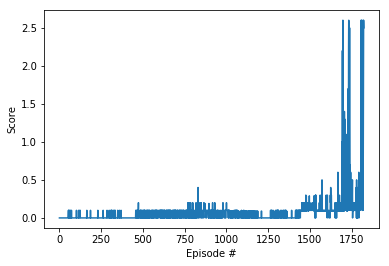

In [18]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, fc1=512, fc2=256)

scores = train_agent(env, agent, run_id = 'larger_network_', 
                     max_episodes = experiment_episodes, noise_start = 0.5)
graph_scores(scores)

## 5.2 Agent with less noise
The Baseline uses an OU Noise Generator with a scale of 0.5; the action space requires outputs in the range -1 to 1; the noise scale and the noise could result in acounts being frequently clipped at the extremes. This could result in frequent actions at the extremes. Training the Agent with a smaller noise scale may reduce the frequency of actions that are clipped in this way and may help the Agent to train better.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.250000
----------------------------------------------

Episode 100	Period Average: 0.00970	Max Period Score: 0.10000	Noise Scale: 0.25000
Episode 200	Period Average: 0.00480	Max Period Score: 0.10000	Noise Scale: 0.25000
Episode 300	Period Average: 0.00280	Max Period Score: 0.10000	Noise Scale: 0.25000
Episode 400	Period Average: 0.03540	Max Period Score: 0.3

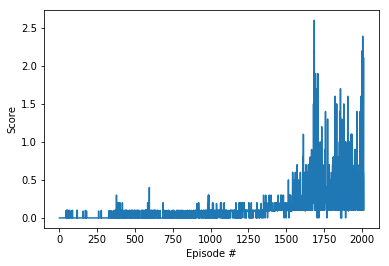

In [19]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents)

scores = train_agent(env, agent, run_id = 'less_noise_', noise_start = 0.25, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.3 Agent with Noise Decay
As the agent's performance improves we may want to reduce the amount of noise so that actions are more aligned with the Policy rather than being overly inflenced by noise. To test this, the following experiment decays the noise over a period of time to determine if this improves performance.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Decaying Noise	 Noise Max: 0.50000	 Noise Min: 0.05000	Decay after 1500 episodes over 500 episodes
----------------------------------------------

Episode 100	Period Average: 0.00600	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00190	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00680	Max Period Score: 0.10000	Noise Scale: 0.5

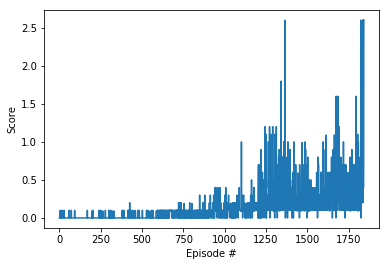

In [20]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents)

scores = train_agent(env, agent, run_id = 'noise_decay_', noise_start = 0.5, min_noise = 0.05,
                    use_noise_decay = True, decay_noise_after = 750, decay_noise_over = 500, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.4 Agent with Adaptive Noise Decay
Exploring the effect of noise further, rather than decaying the noise linerarly over a period of time an adaptive nosie decay scheme was attempted - in this scheme the level of noise used during an episode is related to the average score over the last 100 episode; the closer the agent is getting to the target goal score, the smaller the noise scale.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Adaptive Noise	 Noise Max: 0.50000	 Noise Min: 0.05000
----------------------------------------------

Episode 100	Period Average: 0.00500	Max Period Score: 0.10000	Noise Scale: 0.44550
Episode 200	Period Average: 0.00680	Max Period Score: 0.10000	Noise Scale: 0.44388
Episode 300	Period Average: 0.00790	Max Period Score: 0.10000	Noise Scale: 0.44289
Episode 400	Period Average: 0.02160	Max

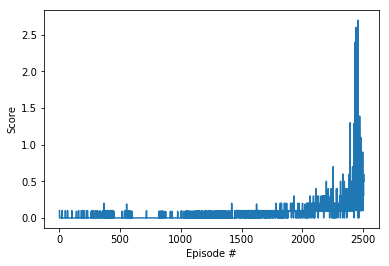

In [21]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents)

scores = train_agent(env, agent, run_id = 'adaptive_noise_decay_', noise_start = 0.5,
                     min_noise = 0.05, use_adaptive_noise=True,
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.5 Agent with smaller Tau
On the Udacity Slack channel, there was frequent mention of the effect of Tau on learning and the Baseline was selected based on the advice provided in that channel. This experement is to determine if, for our Agent, changing the value of Tau affects learning. This experiement uses a smaller value of Tau than the baseline to understand its effect.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.00500
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.00500
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.00290	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00490	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00850	Max Period Score: 0.19000	Noise Scale: 0.50000
Episode 400	Period Average: 0.00360	Max Period Score: 0.0

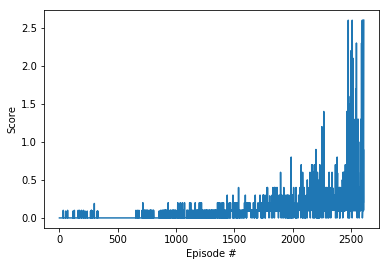

In [22]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, tau = 5e-3)

scores = train_agent(env, agent, run_id = 'smaller_tau', noise_start = 0.5, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.6 Agent with smaller Learning Rates
This experiement is to examine the change in learning behaviour when the Learning Rates for the Critic and Actor are smaller than the baseline.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00050	Critic LR: 0.00005	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00050	Critic LR: 0.00005	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.00700	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00600	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00790	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.00360	Max Period Score: 0.0

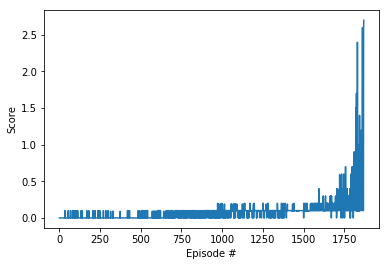

In [23]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, lra=5e-4, lrc= 5e-5)

scores = train_agent(env, agent, run_id = 'smaller_lr', noise_start = 0.5, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.7 Agent with larger Learning Rates
This experiment is to determine the effect of using larger Learning Rates for the Actor and Critic and to observe the behaviour on learning.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00500	Critic LR: 0.00050	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00500	Critic LR: 0.00050	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.00600	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00590	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00890	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.01270	Max Period Score: 0.1

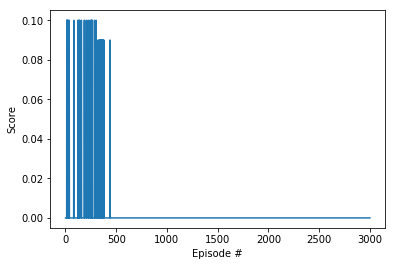

In [24]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, lra=5e-3, lrc= 5e-4)

scores = train_agent(env, agent, run_id = 'larger_lr', noise_start = 0.5, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.8 Agent with Smaller Replay Buffer
During early learning cycles a large replay buffer will still hold older less relvevant expereinces
A smaller replay buffer, while it reduces variety, may result in better learning as older & less relevant entries are discarded sooner. However it carries with it the risk that some useful training samples are lost quicker and may not have been used frequently in a learning batch.

This experiment is to observe the difference in behaviour due to buffer size.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 10000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.00400	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00500	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00390	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.01340	Max Period Score: 0.200

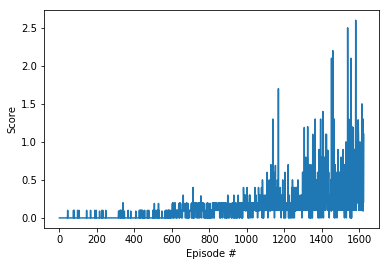

In [25]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, replay_buffer_size = int(1e4))

scores = train_agent(env, agent, run_id = 'smaller_replay_', noise_start = 0.5, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.9 Agent with smaller batch size
The Learning Batch size in the Baseline was chosen based on previous experiemnts with a DDPG agent and this experiment is to understand the behaviour of the agent when smaller batch size is used in MADDPG.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 128	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.00490	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00590	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00600	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.00670	Max Period Score: 0.1

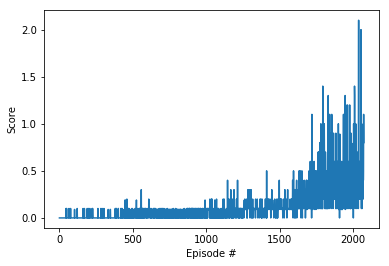

In [26]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, batch_size = 128)

scores = train_agent(env, agent, run_id = 'smaller_batch_', noise_start = 0.5, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.10 Agent with larger batch size
In this experiement we are seeking to understand the behaviour of the Agent when a larger batch size is used.

MADDPG Configuration
	Gamma 0.99000	Batch Size: 512	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.00800	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00790	Max Period Score: 0.19000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00690	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.00380	Max Period Score: 0.1

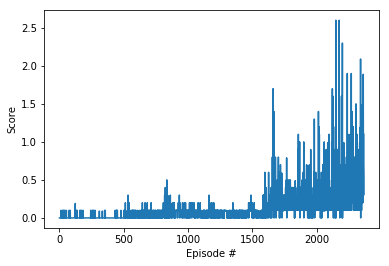

In [27]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, batch_size = 512)

scores = train_agent(env, agent, run_id = 'larger_batch_', noise_start = 0.5, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.11 Agent with multiple learning epochs per step
In this experiment we will observe the Learning Behaviour when the Agent learns multiple batches at each step. This learning will be slower but results in more learning across episodes. 

There is a risk with this approach that earlier untrained behaviours are reinforced and it will take time to unlearn these and replace with new behaviours. 

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 1 step
	Learn 2 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.01000	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00800	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00690	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.02530	Max Period Score: 0.2

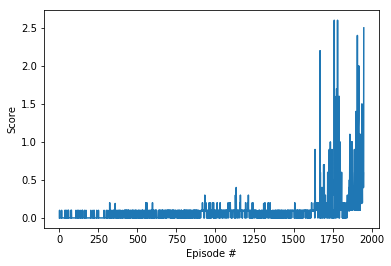

In [28]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, learn_epoch = 2)

scores = train_agent(env, agent, run_id = 'multiple_epochs_per_step', noise_start = 0.5, 
                     max_episodes = experiment_episodes)
graph_scores(scores)

## 5.12 Agent that learns less often
In this experiement we want to observe the learning behaviour when the Agent learns less often. The original MADDPG paper used a single learning batch for each step, in this experiment we will perform a learning batch every other step. 

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 2 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Training Configuration
	Goal period 100	 Goal Score 0.5	Output results every 100 episode
	Constant Noise	Noise Scale: 0.500000
----------------------------------------------

Episode 100	Period Average: 0.00300	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 200	Period Average: 0.00300	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 300	Period Average: 0.00300	Max Period Score: 0.10000	Noise Scale: 0.50000
Episode 400	Period Average: 0.00630	Max Period Score: 0.0

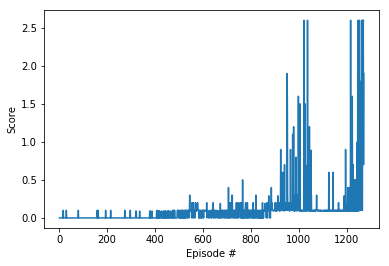

In [29]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, learn_every = 2)

scores = train_agent(env, agent, run_id = 'learn_less_often', noise_start = 0.5,
                     max_episodes = experiment_episodes)
graph_scores(scores)

# 6.0 Watch the trained Agent

In [16]:
set_seeds(RANDOM_SEED)
agent = MADDPG_Agent(state_size = state_size, action_size = action_size,
                     num_agents = num_agents, learn_every = 2)
agent.load("baseline_")

MADDPG Configuration
	Gamma 0.99000	Batch Size: 256	Replay Buffer Size: 1000000
	Start Learning after 300 episodes
	Learn Every 2 step
	Learn 1 times each learning step
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------

Agent Configuration
	Network: 24 -> 256 -> 128 -> 2
	Actor LR: 0.00100	Critic LR: 0.00010	Tau: 0.05000
----------------------------------------------



In [20]:
for i in range(1, 10):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)
        
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {:.5f}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000
Score (max over agents) from episode 2: 0.20000
Score (max over agents) from episode 3: 0.10000
Score (max over agents) from episode 4: 0.10000
Score (max over agents) from episode 5: 0.50000
Score (max over agents) from episode 6: 0.50000
Score (max over agents) from episode 7: 0.90000
Score (max over agents) from episode 8: 0.10000
Score (max over agents) from episode 9: 0.89000


In [ ]:
env.close()